**Классификатор изображений на основе свёрточной сети LeNet**

Евгений Борисов <esborisov@sevsu.ru>

Backpropagation applied to handwritten zip code recognition.    
LeCun Y., Boser B., Denker J.S., Henderson D., Howard R.E., Hubbard W., Jackel L.D.   
Neural Computation 1989 1(4):541-551.    
http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf   

## загружаем данные

In [1]:
from tqdm.auto import tqdm

In [2]:
import torch
import torchvision

# from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as MNIST
from torch.utils.data import DataLoader

from torchvision import transforms

transform  = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((.5),(.5)) ])
data_train = MNIST(root='./data', train=True,  download=True, transform=transform)
data_test  = MNIST(root='./data', train=False, download=True, transform=transform)

target_names = data_train.classes
n_classes = len(target_names)+1

display(data_train.data.shape)
display(n_classes)

torch.Size([60000, 28, 28])

11

In [3]:
# import torch
# import torchvision
# from torchvision import transforms
# from torchvision.datasets import CIFAR10

# transform  = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((.5),(.5)) ])

# data_train = CIFAR10(root='./data', train=True,  download=True, transform=transform)
# data_test = CIFAR10(root='./data', train=False,  download=True, transform=transform)

# target_names = data_train.classes

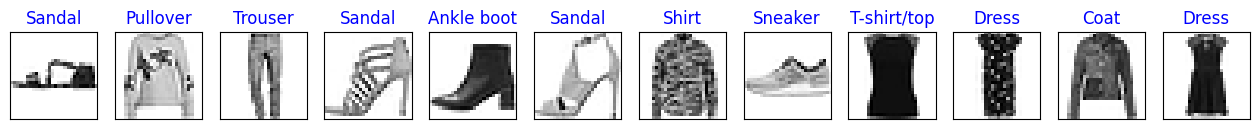

In [4]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

n_show = 12
n_samples = data_train.data.shape[0]
plt.figure(figsize=(16,2))
for n,i in enumerate(rng.permutation(n_samples)[:n_show], start=1):
    img = data_train.data[i]
    plt.subplot(1,n_show,n)
    #plt.axis(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(target_names[ data_train.targets[i]],c='b')
    plt.imshow(img,cmap='gray_r')

## строим модель

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
          ('conv1',  nn.Conv2d(in_channels=1,out_channels=20,kernel_size=3)),
          ('relu1',  nn.ReLU()),
          ('mpool1', nn.MaxPool2d(kernel_size=2) ),
          ('conv2',  nn.Conv2d(in_channels=20,out_channels=64,kernel_size=3)),
          ('relu2',  nn.ReLU()),
          ('flat',   nn.Flatten(start_dim=1) ),
          ('lin1',   nn.Linear(in_features=7744,out_features=n_classes) ),
          # ('lin1',   nn.LazyLinear(out_features=n_classes) ),
          ('smax',   nn.Softmax(dim=-1) ),
        ]))

model

Sequential(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (mpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=7744, out_features=11, bias=True)
  (smax): Softmax(dim=-1)
)

In [8]:
# device = 'cpu'
# with torch.no_grad():
#     for x,target in DataLoader(data_train, batch_size=7, shuffle=False):
#         out = model(x.to(device)).cpu().detach().numpy()
#         break

# display(out.shape)

### обучаем модель

In [9]:
import torch.optim as optim

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) #, momentum=0.9)

# from torch.optim.lr_scheduler import ExponentialLR
# scheduler = ExponentialLR(optimizer, gamma=0.95)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cuda:0


In [ ]:
# from tqdm.auto import tqdm
from torch.utils.data import DataLoader

In [12]:
%%time

n_epoch = 50
history_loss = []
batch_size = 1024*8

for epoch in tqdm(range(n_epoch)):  

    for x,target in DataLoader(data_train, batch_size=batch_size, shuffle=True):
        optimizer.zero_grad() # zero the parameter gradients
        loss = criterion( model(x.to(device)), target.to(device) )  # forward 
        loss.backward() 
        optimizer.step()
        history_loss.append( loss.item() )
    #scheduler.step()

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 7min 36s, sys: 1.68 s, total: 7min 38s
Wall time: 7min 38s


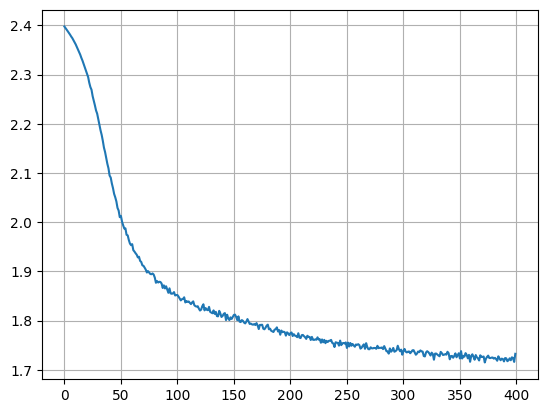

In [13]:
plt.plot(history_loss)
plt.grid()

## тестируем

### учебный датасет

In [14]:
from sklearn.metrics import classification_report

images,label,score = [],[],[]

with torch.no_grad():
    for x,target in DataLoader(data_train, batch_size=batch_size, shuffle=False):
        images.append(x.numpy() ) 
        label.append( target.numpy() )
        score.append( model(x.to(device)).cpu().detach().numpy() )

target = np.hstack(label)
predicted = np.argmax(np.vstack(score),axis=1)
print(  classification_report( target,predicted, target_names=target_names, ) )

              precision    recall  f1-score   support

 T-shirt/top       0.74      0.87      0.80      6000
     Trouser       0.98      0.94      0.96      6000
    Pullover       0.73      0.75      0.74      6000
       Dress       0.83      0.89      0.86      6000
        Coat       0.73      0.78      0.75      6000
      Sandal       0.93      0.93      0.93      6000
       Shirt       0.67      0.45      0.54      6000
     Sneaker       0.90      0.90      0.90      6000
         Bag       0.94      0.95      0.94      6000
  Ankle boot       0.92      0.94      0.93      6000

    accuracy                           0.84     60000
   macro avg       0.84      0.84      0.84     60000
weighted avg       0.84      0.84      0.84     60000



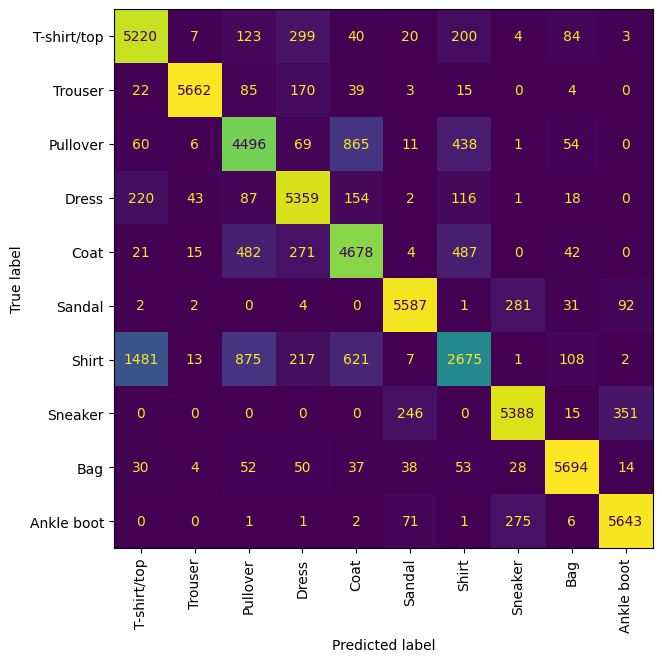

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize=(7,7))
disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(target,predicted), 
        display_labels=target_names,
    )
disp.plot(ax=ax, xticks_rotation='vertical', include_values=True, cmap='viridis',  colorbar=False,)
plt.show()

### тестовый датасет

In [16]:
images,label,score = [],[],[]

with torch.no_grad():
    for x,target in DataLoader(data_test, batch_size=batch_size, shuffle=False):
        images.append(x.numpy() ) 
        label.append( target.numpy() )
        score.append( model(x.to(device)).cpu().detach().numpy() )
np.hstack(label)


target = np.hstack(label)
predicted = np.argmax(np.vstack(score),axis=1)
print(  classification_report( target,predicted, target_names=target_names, ) )

              precision    recall  f1-score   support

 T-shirt/top       0.73      0.85      0.79      1000
     Trouser       0.99      0.94      0.96      1000
    Pullover       0.72      0.75      0.73      1000
       Dress       0.82      0.88      0.85      1000
        Coat       0.71      0.75      0.73      1000
      Sandal       0.94      0.92      0.93      1000
       Shirt       0.61      0.41      0.49      1000
     Sneaker       0.89      0.90      0.89      1000
         Bag       0.93      0.96      0.94      1000
  Ankle boot       0.92      0.94      0.93      1000

    accuracy                           0.83     10000
   macro avg       0.82      0.83      0.82     10000
weighted avg       0.82      0.83      0.82     10000



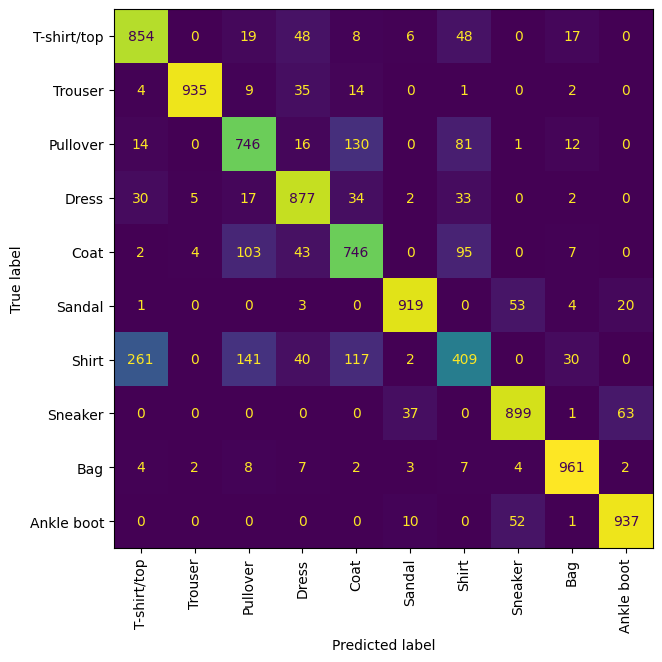

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize=(7,7))
disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(target,predicted), 
        display_labels=target_names,
    )
disp.plot(ax=ax, xticks_rotation='vertical', include_values=True, cmap='viridis',  colorbar=False,)
plt.show()

---

In [22]:
# !pip3 install watermark

In [21]:
# !pip3 install watermark
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions
#

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.13.2

torch      : 2.0.1
numpy      : 1.24.3
torchvision: 0.15.2
matplotlib : 3.7.1



In [ ]:
# # размеры входной картинки
# # (h,w),c = data_train.data.shape[1:],1 # размеры входной картинки

# h,w,c = (
#     data_train.data.shape[1:] 
#     if len(data_train.data.shape)==4 
#     else list(data_train.data.shape[1:])+[1]
# )
# display( (h,w,c) )

In [ ]:
# class LeNet(nn.Module):
    
#     def __init__(self,input_size=(h,w,c), n_class= len(target_names)):
#         super().__init__()
        
#         h,w,c = input_size # размеры входной картинки
        
#         (kh,kw),n_maps = (3,3),64 # размер ядра и количество карт признаков
#         self._conv1 = nn.Conv2d( in_channels=c, out_channels=n_maps, kernel_size=(kh,kw))
#         h,w,c = h-((kh//2)*2), w-((kw//2)*2),n_maps # размеры и количество выходных карт признаков
            
#         ph,pw = (2,2) # размер окна для пулинга
#         self._pool1 = nn.MaxPool2d((ph,pw))
#         h,w = h//ph, w//pw # размеры выходных карт признаков
        
#         (kh,kw),n_maps = (3,3),32 # размер ядра и количество карт признаков
#         self._conv2 = nn.Conv2d( in_channels=c, out_channels=n_maps, kernel_size=(kh,kw))
#         h,w,c = h-((kh//2)*2), w-((kw//2)*2),n_maps # размеры и количество выходных карт признаков
        
# #         ph,pw = (2,2) # размер окна для пулинга
# #         self._pool2 = nn.MaxPool2d((ph,pw))
# #         h,w = h//ph, w//pw # размеры выходных карт признаков
        
#         # выходной слой
#         self._fc1 = nn.Linear(in_features=(h*w*c), out_features=n_class)

#     def forward(self, x):
#         o = F.relu(self._conv1(x))
#         o = self._pool1(o)
#         o = F.relu(self._conv2(o))
#         # o = self._pool2(o)
#         o = F.softmax( self._fc1( torch.flatten(o, start_dim=1) ), dim=1 )
#         return o

In [ ]:
# model = LeNet()
# model